<a href="https://colab.research.google.com/github/AarnoStormborn/Tensorflow-Developer-Certification/blob/main/07_tensorflow_milestone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow: Milestone Project 1

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c75f4d5c-3dd2-f9a0-df79-473b40a632ce)


## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-21 10:22:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-21 10:22:02 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Download and Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use Tensorflow Datasets

In [ ]:
# Get tensorflow datasets
import tensorflow_datasets as tfds

In [ ]:
datasets = tfds.list_builders()
print("food101" in datasets)

True


In [7]:
# Loading the Data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete00GMPW/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete00GMPW/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [8]:
# Features of Food101 
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# Class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Visualize samples


In [14]:
# Take one sample 
one_sample = train_data.take(1)
one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
# Look at the sample
for image, label in one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target Class: {label}
    Class name: {class_names[label.numpy()]}
    """)


    Image shape: (306, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target Class: 29
    Class name: cup_cakes
    


In [16]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

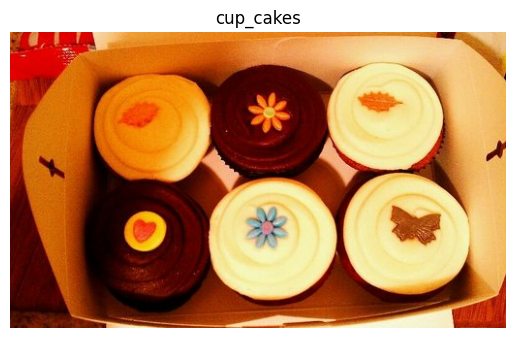

In [17]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)
plt.show()

## Preprocessing Functions

In [22]:
def preprocess(image, label, img_size=224, scale=False):
    
    image = tf.image.resize(image, (img_size, img_size))
    if scale:
        image = image/255.
    return tf.cast(image, tf.float32), label

In [23]:
preprocessed_image, label = preprocess(image, label)
print(preprocessed_image.shape, preprocessed_image.dtype)

(224, 224, 3) <dtype: 'float32'>


## Batch and Prepare Images

In [24]:
# Map preprocessing function to training data and parallelize it
train_data = train_data.map(map_func=preprocess, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create Model Callbacks

* Tensorboard Callback
* Model Checkpoint Callback
* Early Stopping Callback

In [27]:
# Tensorboard Callback
from helper_functions import create_tensorboard_callback

# Model Checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor="val_acc",
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=0)

## Mixed Precision Training

In [31]:
# Turn on Mixed Precision Training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [32]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build Feature Extraction model

In [36]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create Function model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: Uncomment Next line if base model is not EfficientNet
# x = preprocessing.Rescaling(1/255.)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

# Build Model
model = Model(inputs, outputs)

# Compile Model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 activation_1 (Activation)   (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [38]:
# Check Data types of every layer
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
activation_1 True float32 <Policy "float32">


In [40]:
# Fit the feature extraction model
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.25 * len(test_data)),
                    callbacks=[create_tensorboard_callback(dir_name="training logs",
                                                           experiment_name="effNet_food101_model1"),
                               model_checkpoint])

Saving TensorBoard log files to: training logs/effNet_food101_model1/20230521-120257


Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.7204 - accuracy: 0.5807

2368/2368 [==============================] - 200s 78ms/step - loss: 1.7204 - accuracy: 0.5807 - val_loss: 1.1353 - val_accuracy: 0.6956
Epoch 2/5
2368/2368 [==============================] - ETA: 0s - loss: 1.1996 - accuracy: 0.6890

2368/2368 [==============================] - 176s 73ms/step - loss: 1.1996 - accuracy: 0.6890 - val_loss: 1.0349 - val_accuracy: 0.7216
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 1.0547 - accuracy: 0.7219

2368/2368 [==============================] - 185s 77ms/step - loss: 1.0547 - accuracy: 0.7219 - val_loss: 1.0019 - val_accuracy: 0.7272
Epoch 4/5
2368/2368 [==============================] - ETA: 0s - loss: 0.9593 - accuracy: 0.7458

2368/2368 [==============================] - 175s 73ms/step - loss: 0.9593 - accuracy: 0.7458 - val_loss: 0.9842 - val_accuracy: 0.7300
Epoch 5/5
2368/2368 [==============================] - ETA: 0s - loss: 0.8897 - accuracy: 0.7653

2368/2368 [==============================] - 188s 79ms/step - loss: 0.8897 - accuracy: 0.7653 - val_loss: 0.9733 - val_accuracy: 0.7330


In [41]:
# Evaluate on entire test set
model.evaluate(test_data)

790/790 [==============================] - 51s 64ms/step - loss: 0.9775 - accuracy: 0.7330


[0.9774741530418396, 0.7330297231674194]